## 文本摘要任务
文本摘要同样是seq2seq，旨在尽可能保留文本语义的情况下将长文本压缩为短文本。
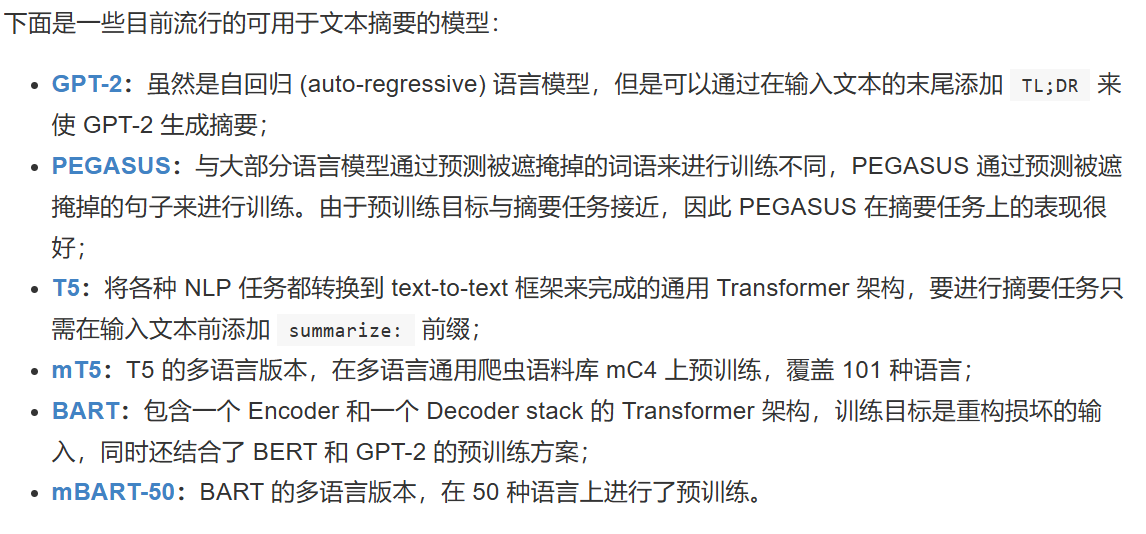

T5 模型通过模板前缀 (prompt prefix) 将各种 NLP 任务都转换到 text-to-text 框架进行预训练，例如摘要任务的前缀就是` summarize:`
![T5](./img/T5model.png)

# 数据加载和处理
- data:我们选择大规模中文短文本摘要语料库 LCSTS 作为数据集[鲸鱼社区](https://www.heywhale.com/mw/dataset/5f05ae9c3af6a6002d0f0997/file) 或 [百度网盘](https://pan.baidu.com/s/10zbcluvILlL8J-KnX56Fgw?pwd=xszb)
- model: BUET CSE NLP Group 提供的 mT5 摘要模型

In [1]:
# 构建数据集
from torch.utils.data import Dataset

max_dataset_size = 200_000
batch_size = 32

class LCSTS(Dataset):
    def __init__(self, file):
        self.data = self.load_data(file)
    
    def load_data(self, file):
        Data = {}
        with open(file, "rt", encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if idx >= max_dataset_size:
                    break
                items = line.strip().split("!=!")
                assert len(items) == 2
                Data[idx] ={
                    'title': items[0],
                    'content': items[1]
                }
        return Data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 加载数据
train_data = LCSTS('dataset/LCSTS/data1.tsv')
valid_data = LCSTS('dataset/LCSTS/data2.tsv')
test_data = LCSTS('dataset/LCSTS/data3.tsv')

In [2]:
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 200000
valid set size: 10666
test set size: 1106
{'title': '修改后的立法法全文公布', 'content': '新华社受权于18日全文播发修改后的《中华人民共和国立法法》，修改后的立法法分为“总则”“法律”“行政法规”“地方性法规、自治条例和单行条例、规章”“适用与备案审查”“附则”等6章，共计105条。'}


In [ ]:
!python -m pip show protobuf

Name: protobuf
Version: 4.25.8
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: /root/miniconda3/envs/state1/lib/python3.10/site-packages
Requires: 
Required-by: 


In [4]:
# 我们选择 BUET CSE NLP Group 提供的 mT5 摘要模型
from transformers import AutoTokenizer

model_name = "./model/mT5_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/miniconda3/envs/state1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/root/miniconda3/envs/state1/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practi

In [5]:
# 测试分词效果
inputs = tokenizer("我叫张三，在苏州大学学习计算机。")
print(inputs)
print(tokenizer.convert_ids_to_tokens(inputs.input_ids))

{'input_ids': [259, 3003, 27333, 8922, 2092, 261, 1083, 117707, 9792, 24920, 123553, 306, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['▁', '我', '叫', '张', '三', ',', '在', '苏州', '大学', '学习', '计算机', '。', '</s>']


Unicode 字符 `▁` 以及序列结束 token `</s>` 表明 mT5 模型采用的是基于 `Unigram 切分算法的`

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM

max_input_len = 512
max_target_len = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.to(device)

def collote_fn(batch_samples):
    batch_inputs, batch_targets = [], []
    for sample in batch_samples:
        batch_inputs.append(sample['content'])
        batch_targets.append(sample['title'])

    batch_data = tokenizer(
        batch_inputs, 
        padding=True, 
        max_length=max_input_len,
        truncation=True, 
        return_tensors="pt"
    )

    # 并行地对输入和标签进行分词
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch_targets, 
            padding=True, 
            max_length=max_target_len,
            truncation=True, 
            return_tensors="pt"
        )["input_ids"]
        
        # 标签进行移位操
        batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(labels)
        end_token_index = torch.where(labels == tokenizer.eos_token_id)[1]
        for idx, end_idx in enumerate(end_token_index):
            labels[idx][end_idx+1:] = -100
        batch_data['labels'] = labels
    return batch_data

Using cuda device



```python
labels = tokenizer(
        text_target=batch_targets,  # 关键改动：使用 text_target 参数
        padding=True,
        max_length=max_target_len,
        truncation=True,
        return_tensors="pt"
        )
UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
```

In [7]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collote_fn)

In [8]:
# 尝试打印出一个 batch 的数据，以验证是否处理正确
batch = next(iter(train_dataloader))
print(batch.keys())
print('batch shape:', {k: v.shape for k, v in batch.items()})
print(batch)

KeysView({'input_ids': tensor([[   259, 194416,   2518,  ...,      0,      0,      0],
        [   259, 101737,  36059,  ...,      0,      0,      0],
        [   259,  11688,   4444,  ...,      1,      0,      0],
        ...,
        [   259,   1083,  77554,  ...,      0,      0,      0],
        [145764,   8333,  72472,  ...,      0,      0,      0],
        [   259, 178082,  35011,  ...,      0,      0,      0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_input_ids': tensor([[     0,    259,   8922,  79140,  10325,  14993,  23035,  16374,  17684,
          16408,  10325,  14993,  42254,  11022,  80960,      1,      0,      0,
              0,      0,      0,      0,      0,      0],
        [     0,    259, 193114,   2910, 114129,  20075,  35843, 164834,  18803,
         218782,  4

/root/miniconda3/envs/state1/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


## 训练模型
直接使用 Transformers 库自带的 `AutoModelForSeq2SeqLM` 函数来构建模型，因此下面只需要实现 Epoch 中的”`训练循环”和”验证/测试循环”`

In [9]:
from tqdm.auto import tqdm

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    return total_loss

In [10]:
from rouge import Rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

rouge = Rouge()

scores = rouge.get_scores(
    hyps=[generated_summary], refs=[reference_summary]
)[0]
scores

{'rouge-1': {'r': 1.0, 'p': 0.8571428571428571, 'f': 0.9230769181065088},
 'rouge-2': {'r': 0.8, 'p': 0.6666666666666666, 'f': 0.7272727223140496},
 'rouge-l': {'r': 1.0, 'p': 0.8571428571428571, 'f': 0.9230769181065088}}

!! rouge 库默认使用`空格进行分词`，因此无法处理中文、日文等语言，`最简单的办法是按字进行切分`，当然也可以使用分词器分词后再进行计算，否则会计算出不正确的 ROUGE 值：

In [11]:
from rouge import Rouge

generated_summary = "我在苏州大学学习计算机，苏州大学很美丽。"
reference_summary = "我在环境优美的苏州大学学习计算机。"

rouge = Rouge()

TOKENIZE_CHINESE = lambda x: ' '.join(x)

scores = rouge.get_scores(
    hyps=[TOKENIZE_CHINESE(generated_summary)],
    refs=[TOKENIZE_CHINESE(reference_summary)]
)[0]
print('ROUGE:', "\n", scores)
scores = rouge.get_scores(
    hyps=[generated_summary], 
    refs=[reference_summary]
)[0]
print('wrong ROUGE:', "\n", scores)

ROUGE: 
 {'rouge-1': {'r': 0.75, 'p': 0.8, 'f': 0.7741935433922998}, 'rouge-2': {'r': 0.5625, 'p': 0.5625, 'f': 0.562499995}, 'rouge-l': {'r': 0.6875, 'p': 0.7333333333333333, 'f': 0.7096774143600416}}
wrong ROUGE: 
 {'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}


我们可以直接调用预训练好的 mT5 摘要模型生成摘要（generate(), 并使用柱搜索解码，num_beams=4，并且不允许出现 2-gram 重复）：

```py
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model_checkpoint = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

article_text = """
受众在哪里，媒体就应该在哪里，媒体的体制、内容、技术就应该向哪里转变。
媒体融合关键是以人为本，即满足大众的信息需求，为受众提供更优质的服务。
这就要求媒体在融合发展的过程中，既注重技术创新，又注重用户体验。
"""

input_ids = tokenizer(
    article_text,
    return_tensors="pt",
    truncation=True,
    max_length=512
)
generated_tokens = model.generate(
    input_ids["input_ids"],
    attention_mask=input_ids["attention_mask"],
    max_length=32,
    no_repeat_ngram_size=2,
    num_beams=4
)
summary = tokenizer.decode(
    generated_tokens[0],
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(summary)
```

```md
_________________________
Using cpu device
媒体融合发展是当下中国面临的一大难题。
```

In [13]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model_checkpoint = model_name
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

article_text =[ """
受众在哪里，媒体就应该在哪里，媒体的体制、内容、技术就应该向哪里转变。
媒体融合关键是以人为本，即满足大众的信息需求，为受众提供更优质的服务。
这就要求媒体在融合发展的过程中，既注重技术创新，又注重用户体验。
""",
"""
新华社受权于18日全文播发修改后的《中华人民共和国立法法》，
修改后的立法法分为“总则”“法律”“行政法规”“地方性法规、
自治条例和单行条例、规章”“适用与备案审查”“附则”等6章，共计105条。
"""
]

input_ids = tokenizer(
    article_text,
    padding=True, 
    return_tensors="pt",
    truncation=True,
    max_length=512
).to(device)
generated_tokens = model.generate(
    input_ids["input_ids"],
    attention_mask=input_ids["attention_mask"],
    max_length=32,
    no_repeat_ngram_size=2,
    num_beams=4
)
summary = tokenizer.batch_decode(
    generated_tokens,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(summary, generated_tokens, type(generated_tokens.cpu().numpy()))

Using cuda device


/root/miniconda3/envs/state1/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


['媒体融合发展是当下中国面临的一大难题。', '中国官方新华社周一(18日)全文播发修改后的《中华人民共和国立法法》。'] tensor([[     0,    259,  38455,  91296,  11173,   1543, 214520,   3161, 131990,
            493, 171732, 186263,    306,      1,      1,      1,      1,      1,
              1,      1,      1],
        [     0,    259,   3161,   3641, 166129,   9692,   1374, 115863,    838,
            271, 143439,  31985,   5685, 108962, 107060,   2518, 185064, 164411,
           4066, 149709,      1]], device='cuda:0') <class 'numpy.ndarray'>


注意在test_loop循环里需要将预测结果和正确标签都处理为 rouge 库接受的文本列表格式

In [14]:
import numpy as np
from rouge import Rouge

rouge = Rouge()

def test_loop(dataloader, model):
    preds, labels = [], []
    
    model.eval()
    for batch_data in tqdm(dataloader):
        batch_data = batch_data.to(device)

        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_len,
                num_beams=4,              # 束搜索
                no_repeat_ngram_size=2,   # 不允许出现2-gram 重复
            ).cpu().numpy()

        # 默认 type 为tensor（防御性代码检测tuple）
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        # ！！注意，因为是中文字符，所以使用 " " 进行隔开
        preds += [' '.join(pred.strip()) for pred in decoded_preds]
        labels += [' '.join(label.strip()) for label in decoded_labels]

    scores = rouge.get_scores(hyps=preds, refs=labels, avg=True)
    result = {key: value['f'] * 100 for key, value in scores.items()}
    result['avg'] = np.mean(list(result.values()))
    print(f"Rouge1: {result['rouge-1']:>0.2f} Rouge2: {result['rouge-2']:>0.2f} RougeL: {result['rouge-l']:>0.2f}\n")
    return result

## 训练部分 

In [15]:
test_data = LCSTS('./dataset/LCSTS/data3.tsv')
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collote_fn)

test_loop(test_dataloader, model)

  0%|                                                                                                                                                                  | 0/35 [00:00<?, ?it/s]/root/miniconda3/envs/state1/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:47<00:00,  1.36s/it]


Rouge1: 23.71 Rouge2: 12.20 RougeL: 20.78



{'rouge-1': 23.70973606970255,
 'rouge-2': 12.201556574706865,
 'rouge-l': 20.778284839466945,
 'avg': np.float64(18.896525827958786)}

In [16]:
from transformers import get_scheduler
from torch.optim import AdamW

learning_rate = 2e-5
epoch_num = 3

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

total_loss = 0.
best_avg_rouge = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    valid_rouge = test_loop(valid_dataloader, model)
    print(valid_rouge)
    rouge_avg = valid_rouge['avg']
    if rouge_avg > best_avg_rouge:
        best_avg_rouge = rouge_avg
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'epoch_{t+1}_valid_rouge_{rouge_avg:0.4f}_model_weights.bin')
print("Done!")

Epoch 1/3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [03:46<00:00,  1.48it/s]


Rouge1: 34.18 Rouge2: 21.42 RougeL: 31.17

{'rouge-1': 34.18052404435182, 'rouge-2': 21.41615757342477, 'rouge-l': 31.168922628875816, 'avg': np.float64(28.92186808221747)}
saving new weights...

Epoch 2/3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [03:44<00:00,  1.49it/s]


Rouge1: 34.57 Rouge2: 21.74 RougeL: 31.52

{'rouge-1': 34.565778436441605, 'rouge-2': 21.74354374349282, 'rouge-l': 31.52090540381479, 'avg': np.float64(29.276742527916408)}
saving new weights...

Epoch 3/3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [03:37<00:00,  1.54it/s]


Rouge1: 34.69 Rouge2: 21.86 RougeL: 31.61

{'rouge-1': 34.69358184470284, 'rouge-2': 21.85681753618554, 'rouge-l': 31.605170635239322, 'avg': np.float64(29.3851900053759)}
saving new weights...

Done!


# 保存和测试模型


In [18]:
test_data = LCSTS('dataset/LCSTS/data3.tsv')
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collote_fn)

import json

model.load_state_dict(torch.load('epoch_3_valid_rouge_29.3852_model_weights.bin'))

beam_size = 4
no_repeat_ngram_size = 2

model.eval()
with torch.no_grad():
    print('evaluating on test set...')
    sources, preds, labels = [], [], []
    for batch_data in tqdm(test_dataloader):
        batch_data = batch_data.to(device)
        generated_tokens = model.generate(
            batch_data["input_ids"],
            attention_mask=batch_data["attention_mask"],
            max_length=max_target_len,
            num_beams=beam_size,
            no_repeat_ngram_size=no_repeat_ngram_size,
        ).cpu().numpy()
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_sources = tokenizer.batch_decode(
            batch_data["input_ids"].cpu().numpy(), 
            skip_special_tokens=True, 
            use_source_tokenizer=True
        )
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        sources += [source.strip() for source in decoded_sources]
        preds += [pred.strip() for pred in decoded_preds]
        labels += [label.strip() for label in decoded_labels]
    scores = rouge.get_scores(
        hyps=[' '.join(pred) for pred in preds], 
        refs=[' '.join(label) for label in labels], 
        avg=True
    )
    rouges = {key: value['f'] * 100 for key, value in scores.items()}
    rouges['avg'] = np.mean(list(rouges.values()))
    print(f"Test Rouge1: {rouges['rouge-1']:>0.2f} Rouge2: {rouges['rouge-2']:>0.2f} RougeL: {rouges['rouge-l']:>0.2f}\n")
    results = []
    print('saving predicted results...')
    for source, pred, label in zip(sources, preds, labels):
        results.append({
            "document": source, 
            "prediction": pred, 
            "summarization": label
        })
    with open('test_data_pred.json', 'wt', encoding='utf-8') as f:
        for exapmle_result in results:
            f.write(json.dumps(exapmle_result, ensure_ascii=False) + '\n')

evaluating on test set...


  0%|                                                                                                                                                                  | 0/35 [00:00<?, ?it/s]/root/miniconda3/envs/state1/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:25<00:00,  1.40it/s]


Test Rouge1: 34.21 Rouge2: 20.81 RougeL: 31.06

saving predicted results...
